In [2]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def select_func(x):
    if isinstance(x, list):
        return x[0]
    elif isinstance(x, dict):
        return x.get('correctness', 'failed')
    else:
        return x

In [4]:
import xml.etree.ElementTree as ET
import ast

def append_root_tags(string):
    if not string.strip().startswith("<root>"):
        string = "<root>\n" + string
    if not string.strip().endswith("</root>"):
        string += "\n</root>"
    return string

def parse_xml_to_dict(xml_string: str):
    """Parse the XML string to a dictionary.

    :param xml_string: The XML string to parse.
    :return: A tuple of (output, reasoning).
    """
    # Append root tags if necessary
    # print(xml_string)
    xml_string = append_root_tags(xml_string)

    # remove comments
    remove_comment_func = lambda string: string.split('//')[0].rstrip() if '//' in string else string
    xml_string = '\n'.join(remove_comment_func(line) for line in xml_string.split('\n'))
    
    # Parse the XML string
    root = ET.fromstring(xml_string)

    # Find the 'final_answer' tag
    final_answer_element = root.find('final_answer')

    # Find the 'reasoning' tag
    reasoning = root.find('reasoning').text.strip()

    # Convert the 'final_answer' tag to a dictionary
    output = ast.literal_eval(final_answer_element.text.strip())
    # print(reasoning_element.text)
    return output, reasoning

#### Extract model performance

In [11]:
model_performance = []
RESULT_DIR = '../../Results'
for file in os.listdir(RESULT_DIR):
    if file.endswith('.json'):
        model = file.split('_')[0]
        problem = file.split('_')
        problem = "_".join(problem[1:])
        problem = problem.split('.')[0]
        with open(RESULT_DIR + '/' + file) as f:
            correct = []
            for line in f.readlines()[-1:]:
                data = json.loads(line)
                for x in data:
                    correctness = select_func(x.get('correctness', 'failed'))
                    if not isinstance(correctness, bool): 
                        correctness = 'failed'
                    # the output can be a string or a dictionary
                    # if (not correctness) and (not isinstance(x.get('output', None), dict)):
                    #     # if it is a string, try to parse it to a dictionary
                    #     # reusing the parse_xml_to_dict function
                    #     # if it fails, then the case is actually failed
                    #     if isinstance(x.get('output', None), str):
                    #         try:
                    #             output, _ = parse_xml_to_dict(x.get('output', None))
                    #             if not isinstance(output, dict):
                    #                 correctness = 'failed'
                    #         except:
                    #             correctness = 'failed'
                    correct.append(correctness)
            performance = {
                'model': model,
                'problem': problem,
                'correct': correct
            }
            model_performance.append(performance)

#### Calculate model accuracy

In [12]:
def calculate_accuracy(expr_result):
    model_name = expr_result['model']
    problem_name = expr_result['problem']
    correct = expr_result['correct']
    assert len(correct) == 100, f'Incorrect number of results for {model_name} on {problem_name} with {len(correct)} results'
    origin_level_correctness = [correct[i:i+10] for i in range(0, len(correct), 10)]
    filter_failed = lambda x: [y for y in x if y != 'failed']
    level_correctness = [filter_failed(x) for x in origin_level_correctness]
    failed_expr = [10 - len(x) for x in level_correctness]
    failed_num = sum(failed_expr)
    failed_expr = [x / 10 for x in failed_expr]
    if failed_num > 0:
        print(f'{model_name} on {problem_name} has {failed_num} failed results')
    level_accuracy = []
    for x in level_correctness:
        if len(x) == 0:
            level_accuracy.append(0)
        else:
            level_accuracy.append(sum(x) / 10)
    return {
        'model': model_name,
        'problem': problem_name,
        'accuracy': level_accuracy,
        'failed': failed_expr,
        'level_correctness': origin_level_correctness
    }

#### Export to a csv file

In [13]:
result_df = []
for expr_result in model_performance:
    result = calculate_accuracy(expr_result)
    expr_df = pd.DataFrame(columns=['model', 'problem', 'level', 'Average accuracy', 'Failure'])
    model_name = result['model']
    problem_name = result['problem']
    accuracy = result['accuracy']
    failed = result['failed']
    problem_map = {
        'sppResults': 'p', 'mfpResults': 'p', 'bspResults': 'p',
        'tsp_d_Results': 'np-cmp', 'gcp_d_Results': 'np-cmp', 'kspResults': 'np-cmp',
        'tspResults': 'np-hard', 'gcpResults': 'np-hard', 'mspResults': 'np-hard',
    }
    expr_df['model'] = [model_name] * 10
    expr_df['problem'] = [problem_name] * 10
    expr_df['level'] = [f'Lvl {i+1}' for i in range(10)]
    expr_df['Average accuracy'] = accuracy
    expr_df['weighted_accuracy'] = [x * (i+1) / 55 for i, x in enumerate(accuracy)]
    expr_df['Failure'] = failed
    expr_df['weighted_failed'] = [x / 10 for i, x in enumerate(failed)]
    expr_df['complexity'] = [problem_map[problem_name]] * 10
    expr_df['lvl_correctness'] = result['level_correctness']
    close_models = ['gpt-4-1106-preview', 'gpt-3.5-turbo', 'claude-2', 'claude-instant-1.2', 'chat-bison@001']
    expr_df['is_close'] = [model_name in close_models] * 10
    result_df.append(expr_df)
result_df = pd.concat(result_df)

claude-instant-1.2 on sppResults has 4 failed results
chat-bison@001 on tspResults has 61 failed results
gpt-4-1106-preview on tspResults has 1 failed results
claude-2 on mspResults has 4 failed results
claude-instant-1.2 on mspResults has 5 failed results
gpt-4-1106-preview on kspResults has 1 failed results
claude-2 on tspResults has 11 failed results
chat-bison@001 on mspResults has 71 failed results
gpt-4-1106-preview on mspResults has 10 failed results
claude-instant-1.2 on gcpResults has 1 failed results
chat-bison@001 on mfpResults has 1 failed results
gpt-3.5-turbo on tspResults has 1 failed results
gpt-4-1106-preview on sppResults has 2 failed results
claude-2 on gcpResults has 1 failed results
claude-instant-1.2 on tspResults has 3 failed results


#### Basic setup

In [14]:
result_df.model.unique()

array(['vicuna', 'mistral', 'yi', 'claude-instant-1.2', 'gpt-3.5-turbo',
       'phi', 'chat-bison@001', 'gpt-4-1106-preview', 'claude-2', 'mpt'],
      dtype=object)

In [15]:
close_models = ['gpt-4-1106-preview', 'gpt-3.5-turbo', 'claude-2', 'claude-instant-1.2', 'chat-bison@001']


open_model_df = result_df[result_df['is_close'] == False]
close_model_df = result_df[result_df['is_close'] == True]

problem_set = result_df['problem'].unique()

In [16]:
result_df.problem.unique()

array(['gcp_d_Results', 'mfpResults', 'sppResults', 'mspResults',
       'tsp_d_Results', 'tspResults', 'kspResults', 'bspResults',
       'gcpResults'], dtype=object)

In [17]:
import numpy as np
def plot_figure(y_name, result_df, prefix=''):
    for x in result_df.complexity.unique():
        data = result_df[result_df['complexity'] == x]
        plt.style.use('ggplot')
        num_models = len(data.model.unique())
        num_problems = len(data.problem.unique())
        # Plot for all models with side by side comparison
        fig, axes = plt.subplots(num_problems, num_models, figsize=(5 * num_models, 3 * num_problems))
        for i, problem in enumerate(data.problem.unique()):
            for j, model in enumerate(data.model.unique()):
                ax = axes[i, j]
                selected_data = data[(data['model'] == model) & (data['problem'] == problem)]
                sns.lineplot(data=selected_data, x='level', y=y_name, ax=ax)
                ax.set_ylabel(f'{problem}')
                ax.set_xlabel(f'{model}')
                ax.set_ylim(0, 1.1)
        fig.suptitle(f'{y_name} for different {prefix} models on {x} problems', fontsize=16, y=1.01)
        fig.text(0.5, -0.02, 'Level', ha='center', fontsize=14)
        fig.text(-0.02, 0.5, y_name, va='center', rotation='vertical', fontsize=14)
        fig.tight_layout()
        fig.savefig(f'figures/{prefix}_model_{y_name}_{x}.png')


def plot_weighted_figure(y_name, result_df, prefix=''):
    df = result_df.copy()
    df['Failure'] = df['Failed']
    df['weighted_accuracy'] = df[y_name] / 10
    if y_name == 'Average accuracy':
        weight_func = lambda x: int(x.split(' ')[1]) / 55
        df['weighted_accuracy'] = df[y_name] * (df['level'].apply(weight_func))
    summary_df = df.groupby(['model', 'problem'], as_index=False).agg({'weighted_accuracy': 'sum', 'problem_order': 'mean'}).reset_index()
    summary_df = summary_df.groupby(['model', 'complexity'], as_index=False).agg({'weighted_accuracy': 'mean'}).reset_index()
    summary_df['complexity'] = summary_df['problem_order'].map({1: 'p', 2: 'np-cmp', 3: 'np-hard'})
    plt.figure(figsize=(20, 6))
    # sns.barplot(data=summary_df, x='problem', y='weighted_accuracy', hue='model')
    sns.lineplot(data=summary_df, x='complexity', y='weighted_accuracy', hue='model', marker='o')
    plt.title(f'Weighted {y_name.lower()} for different {prefix} models on different complexity problems')
    plt.xlabel('Complexity')
    plt.ylabel(f'Weighted {y_name.lower()}')
    plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.savefig(f'figures/{prefix}_model_weighted_{y_name}.png', dpi=300)
    plt.ylim(0, 1)
    # return summary_df.pivot(index='problem', columns='model', values='weighted_accuracy')

# Draw

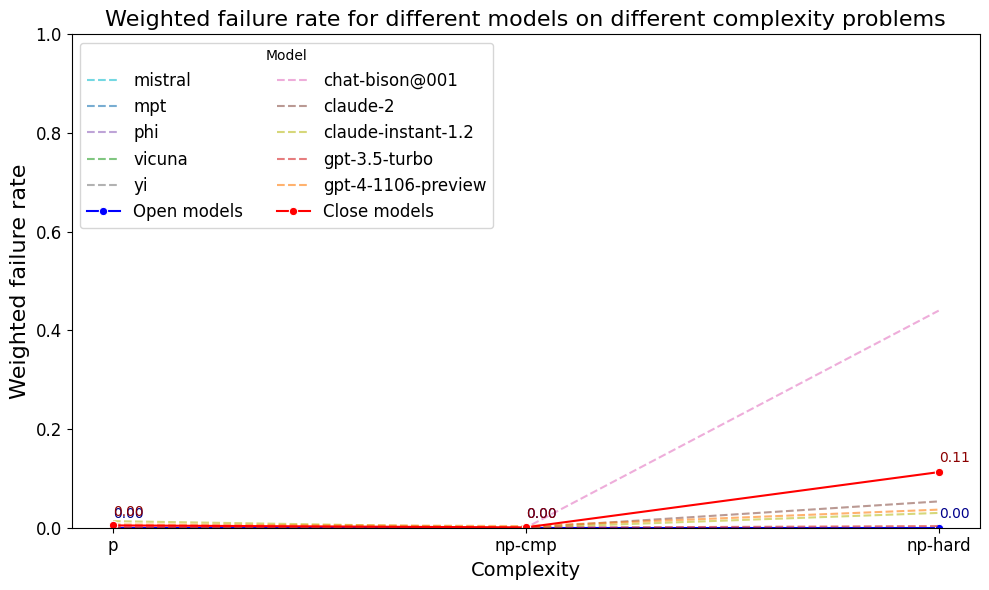

In [25]:
tmp_df = result_df.groupby(['model', 'problem', 'complexity', 'is_close'], as_index=False).agg({
    'Average accuracy': 'mean',
    'weighted_accuracy': 'sum', 
    'weighted_failed': 'sum'
}).reset_index()
# col_name = 'Average accuracy'
# col_name = 'weighted_accuracy'
col_name = 'weighted_failed'
tmp_df = tmp_df.groupby(['model', 'complexity', 'is_close'], as_index=False).agg({col_name: 'mean'}).reset_index()
mean_tmp_df = tmp_df.groupby(['complexity', 'is_close'], as_index=False).agg({col_name: 'mean'})
mean_tmp_df['comp_order'] = mean_tmp_df['complexity'].map({'p': 1, 'np-cmp': 2, 'np-hard': 3})
tmp_df['comp_order'] = tmp_df['complexity'].map({'p': 1, 'np-cmp': 2, 'np-hard': 3})
tmp_df.sort_values(by=['comp_order', 'is_close'], inplace=True)
plt.figure(figsize=(10, 6))
# make one red palette and one blue palette
palette = sns.color_palette("tab10", n_colors=10)
palette = sorted(palette, key=lambda x: x[0] - x[2])
sns.lineplot(data=tmp_df[~tmp_df['is_close']], x='complexity', y=col_name, hue='model', alpha=0.6, linestyle='--', palette=palette[:5])
sns.lineplot(data=mean_tmp_df[~mean_tmp_df['is_close']], x='complexity', y=col_name, color='blue', marker='o', label='Open models')
# annotate the mean value
for i, row in mean_tmp_df[~mean_tmp_df['is_close']].iterrows():
    plt.text(row['comp_order'] - 1, row[col_name] + 0.02, f'{row[col_name]:.2f}', fontsize=10, color='darkblue')
sns.lineplot(data=tmp_df[tmp_df['is_close']], x='complexity', y=col_name, hue='model', alpha=0.6, linestyle='--', palette=palette[5:])
sns.lineplot(data=mean_tmp_df[mean_tmp_df['is_close']], x='complexity', y=col_name, color='red', marker='o', label='Close models')
# annotate the mean value
for i, row in mean_tmp_df[mean_tmp_df['is_close']].iterrows():
    plt.text(row['comp_order'] - 1, row[col_name] + 0.02, f'{row[col_name]:.2f}', fontsize=10, color='darkred')
if col_name == 'weighted_accuracy':
    plt.title(f'Weighted accuracy for different models on different complexity problems', fontsize=18)
    plt.ylabel(f'Weighted accuracy', fontsize=14)
elif col_name == 'Average accuracy':
    plt.title(f'Average accuracy for different models on different complexity problems', fontsize=16)
    plt.ylabel(f'Average accuracy')
else:
    plt.title(f'Weighted failure rate for different models on different complexity problems', fontsize=16)
    plt.ylabel(f'Weighted failure rate', fontsize=16)
plt.xlabel('Complexity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# define how to list the legend with a certain order
plt.tight_layout()
if col_name == 'weighted_failed':
    plt.legend(title='Model', fontsize=12, loc='upper left', ncols=2)
else:
    plt.legend(title='Model', loc='upper right', ncols=2, fontsize=12)
plt.ylim(0, 1)
plt.savefig(f'figures/{col_name}.png', dpi=500, bbox_inches='tight')

In [26]:
tmp_df

,index,model,complexity,is_close,weighted_failed,comp_order
17,17,mistral,p,False,0.000000,1
20,20,mpt,p,False,0.000000,1
23,23,phi,p,False,0.000000,1
26,26,vicuna,p,False,0.000000,1
29,29,yi,p,False,0.000000,1
2,2,chat-bison@001,p,True,0.003333,1
5,5,claude-2,p,True,0.000000,1
8,8,claude-instant-1.2,p,True,0.013333,1
11,11,gpt-3.5-turbo,p,True,0.000000,1
14,14,gpt-4-1106-preview,p,True,0.006667,1


In [20]:
mean_tmp_df

,complexity,is_close,weighted_failed,comp_order
0,np-cmp,False,0.000000,2
1,np-cmp,True,0.000667,2
2,np-hard,False,0.000000,3
3,np-hard,True,0.112667,3
4,p,False,0.000000,1
5,p,True,0.004667,1


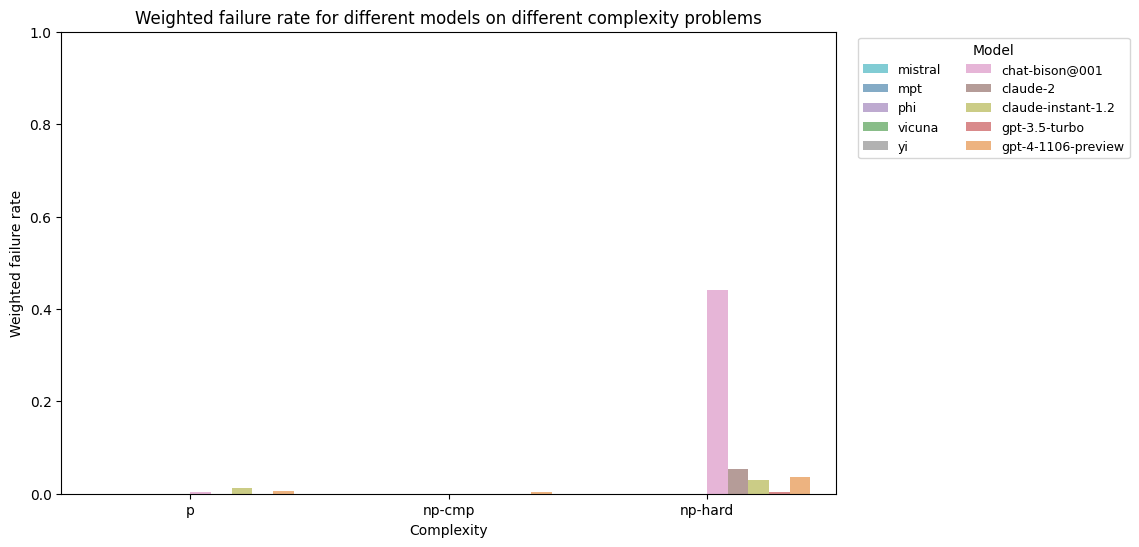

In [21]:
tmp_df = result_df.groupby(['model', 'problem', 'complexity', 'is_close'], as_index=False).agg({
    'Average accuracy': 'mean',
    'weighted_accuracy': 'sum', 
    'weighted_failed': 'sum'
}).reset_index()
col_name = 'weighted_failed'
tmp_df = tmp_df.groupby(['model', 'complexity', 'is_close'], as_index=False).agg({col_name: 'mean'}).reset_index()
mean_tmp_df = tmp_df.groupby(['complexity', 'is_close'], as_index=False).agg({col_name: 'mean'})
tmp_df['comp_order'] = tmp_df['complexity'].map({'p': 1, 'np-cmp': 2, 'np-hard': 3})
tmp_df.sort_values(by=['comp_order', 'is_close'], inplace=True)
plt.figure(figsize=(10, 6))
# make one red palette and one blue palette
palette = sns.color_palette("tab10", n_colors=10)
palette = sorted(palette, key=lambda x: x[0] - x[2])
sns.barplot(data=tmp_df, x='complexity', y=col_name, hue='model', alpha=0.6, palette=palette)
if col_name == 'weighted_accuracy':
    plt.title(f'Weighted average accuracy for different models on different complexity problems')
    plt.ylabel(f'Weighted average accuracy')
elif col_name == 'Average accuracy':
    plt.title(f'Average accuracy for different models on different complexity problems')
    plt.ylabel(f'Average accuracy')
else:
    plt.title(f'Weighted failure rate for different models on different complexity problems')
    plt.ylabel(f'Weighted failure rate')
plt.xlabel('Complexity')
# define how to list the legend with a certain order
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9, ncol=2)
plt.ylim(0, 1)
plt.savefig(f'figures/bar_{col_name}.png', dpi=300)

In [24]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 17 to 13
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            30 non-null     int64  
 1   model            30 non-null     object 
 2   complexity       30 non-null     object 
 3   is_close         30 non-null     bool   
 4   weighted_failed  30 non-null     float64
 5   comp_order       30 non-null     int64  
 6   order            30 non-null     int64  
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 1.7+ KB


In [22]:
plt.figure(figsize=(20, 6))
mapper = {'p': 1, 'np-cmp': 2, 'np-hard': 3}
tmp_df['order'] = tmp_df['complexity'].map(mapper)
sns.barplot(data=tmp_df.sort_values(by=['order', 'is_close']), x='model', y='weighted_accuracy', hue='complexity')
plt.title(f'Weighted average accuracy for different models on different complexity problems')
plt.xlabel('Model')
plt.ylabel(f'Weighted average accuracy')
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylim(0, 1)

ValueError: Could not interpret value `weighted_accuracy` for `y`. An entry with this name does not appear in `data`.

<Figure size 2000x600 with 0 Axes>

In [23]:
# use the heatmap to show the performance of different models on different problems

# reorder the columns
pivot_tb = tmp_df.pivot(index='model', columns='complexity', values='weighted_accuracy').sort_values(by='p', ascending=False)
pivot_tb = pivot_tb.reindex(columns=['p', 'np-cmp', 'np-hard'])
sns.heatmap(pivot_tb, annot=True, cmap='YlGnBu')

KeyError: 'weighted_accuracy'

##### Open models

In [ ]:
import os

if not os.path.exists('figures'):
    os.makedirs('figures')

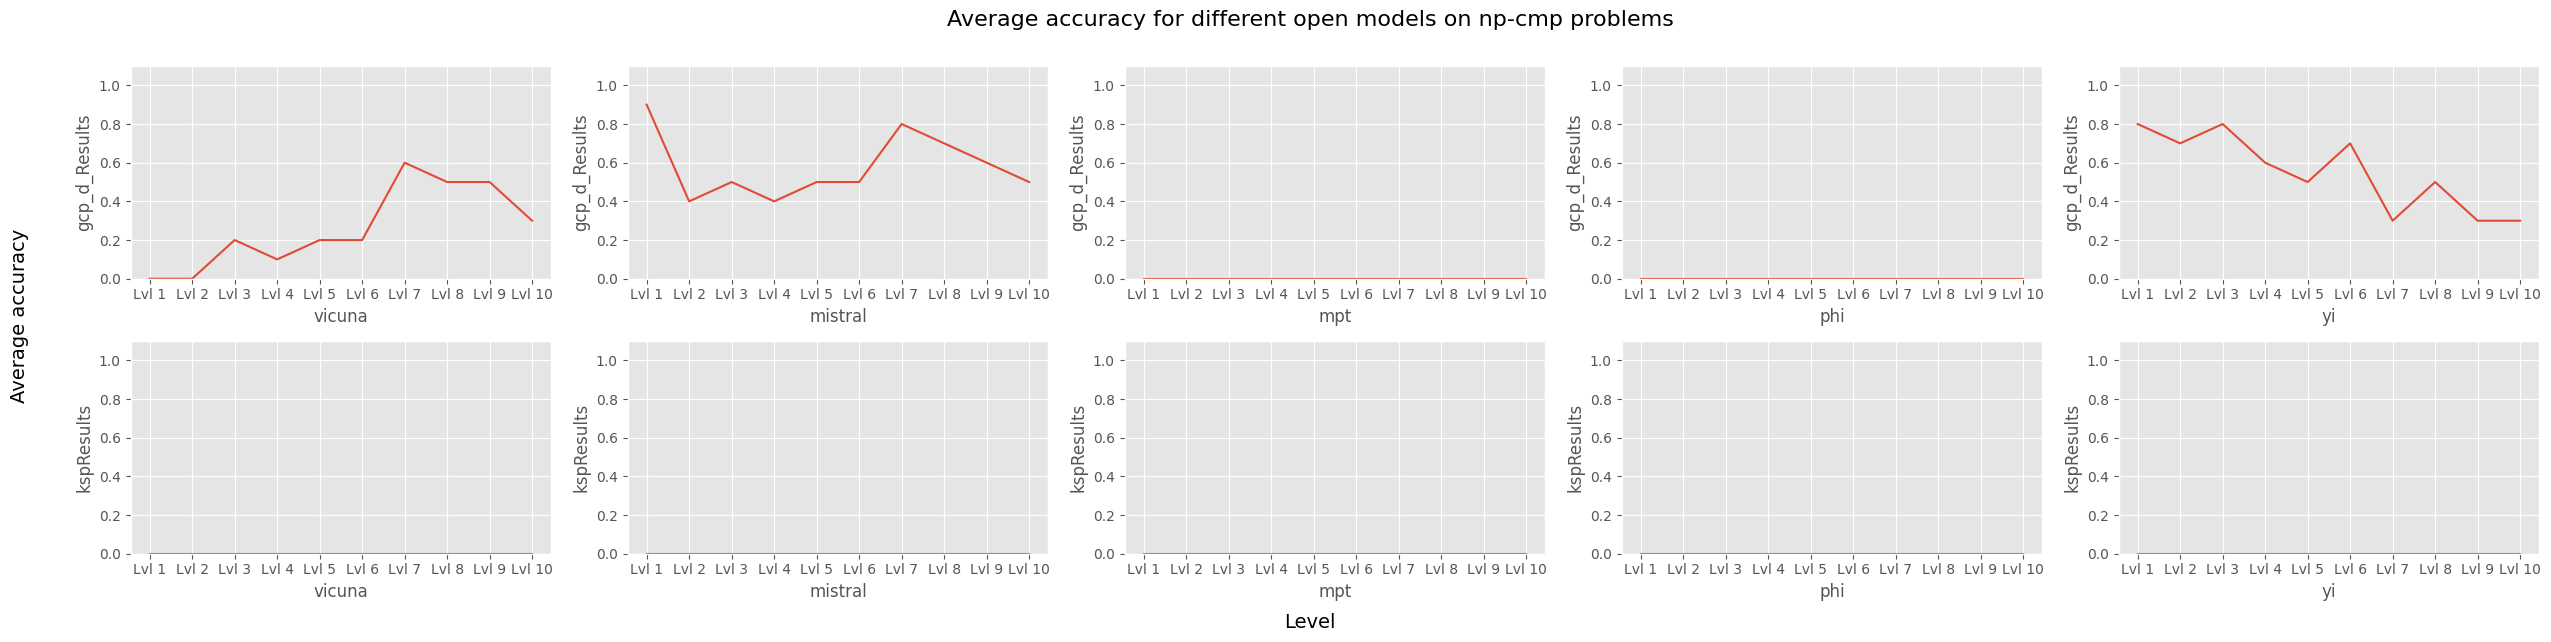

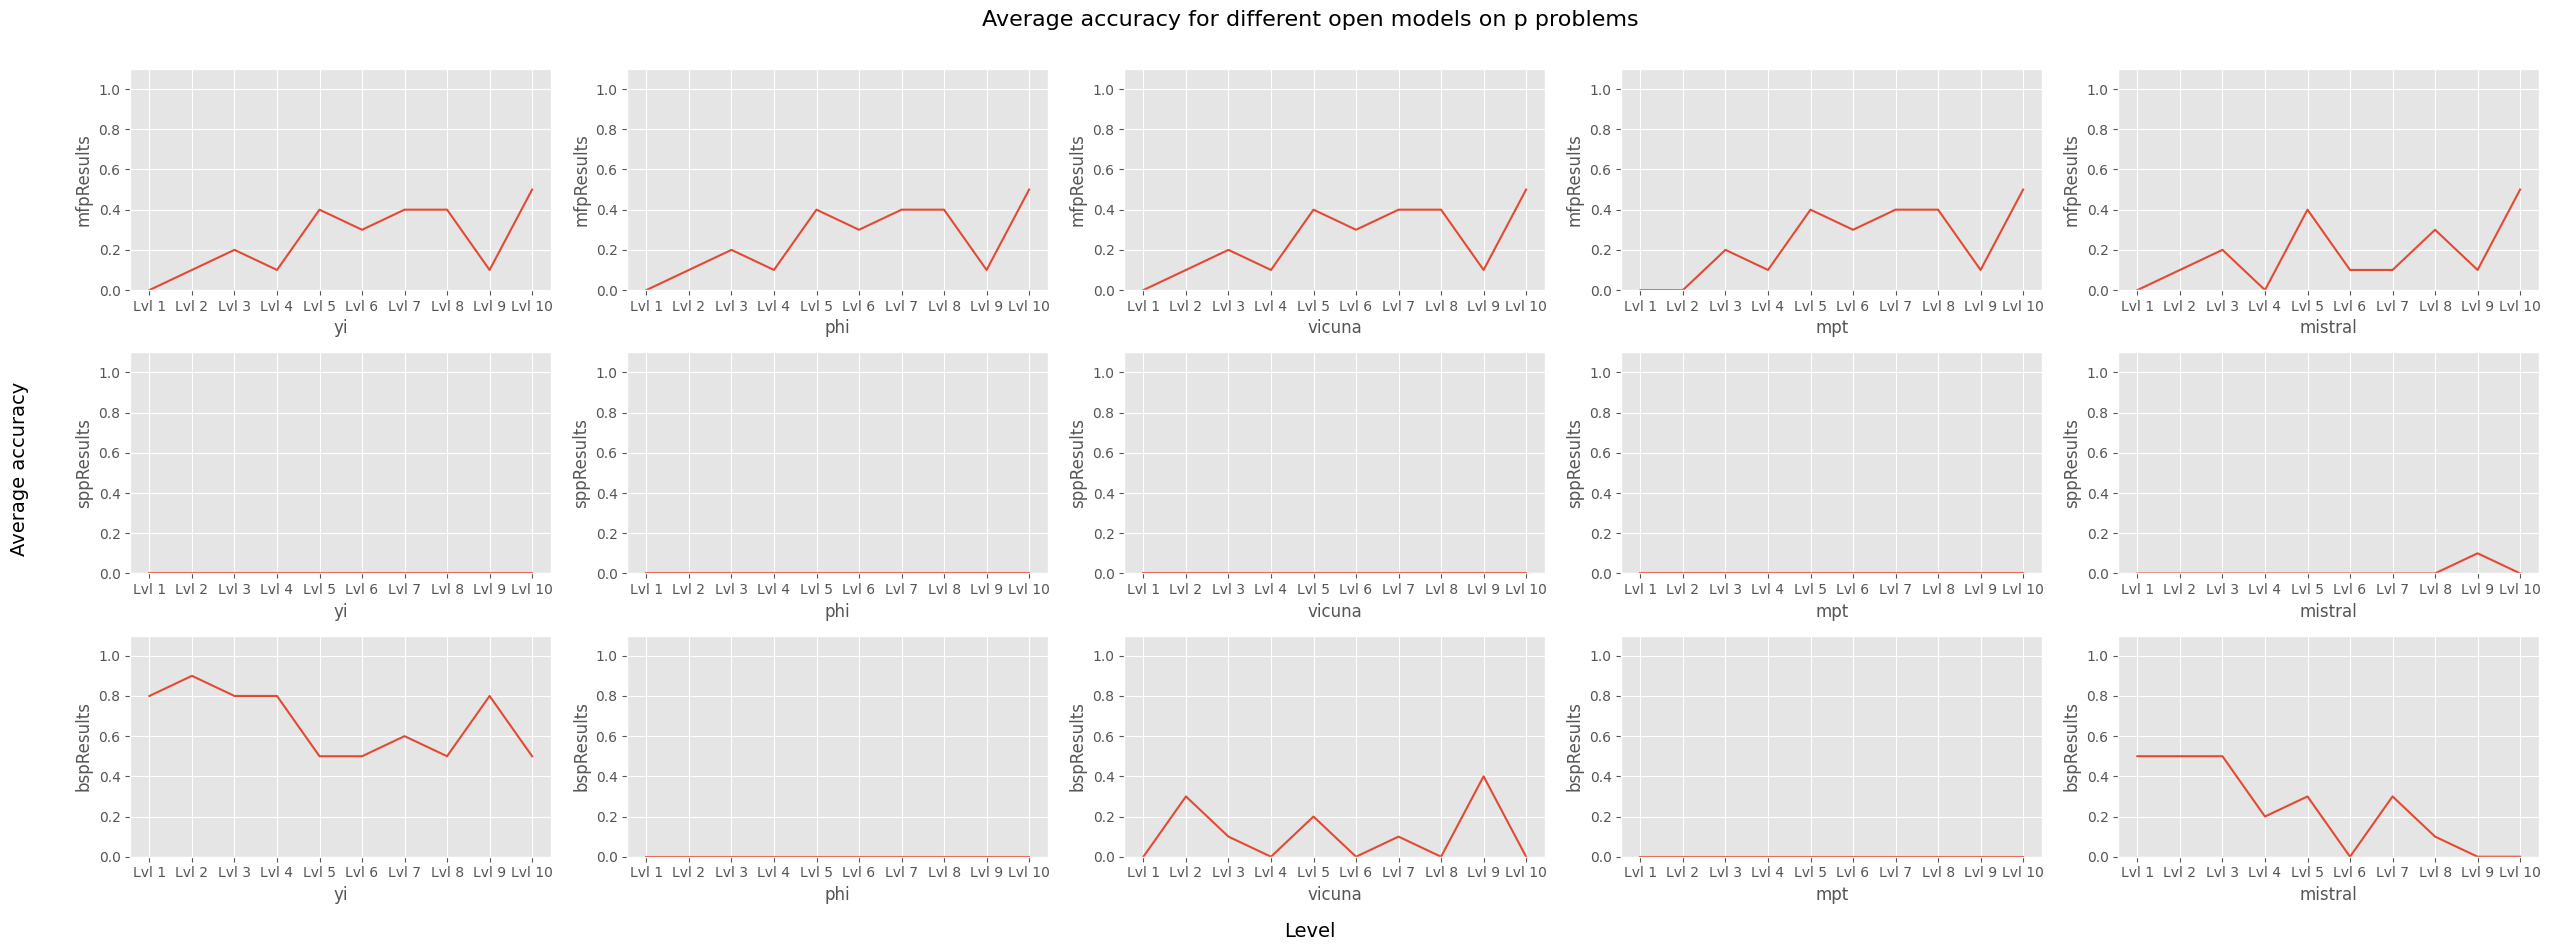

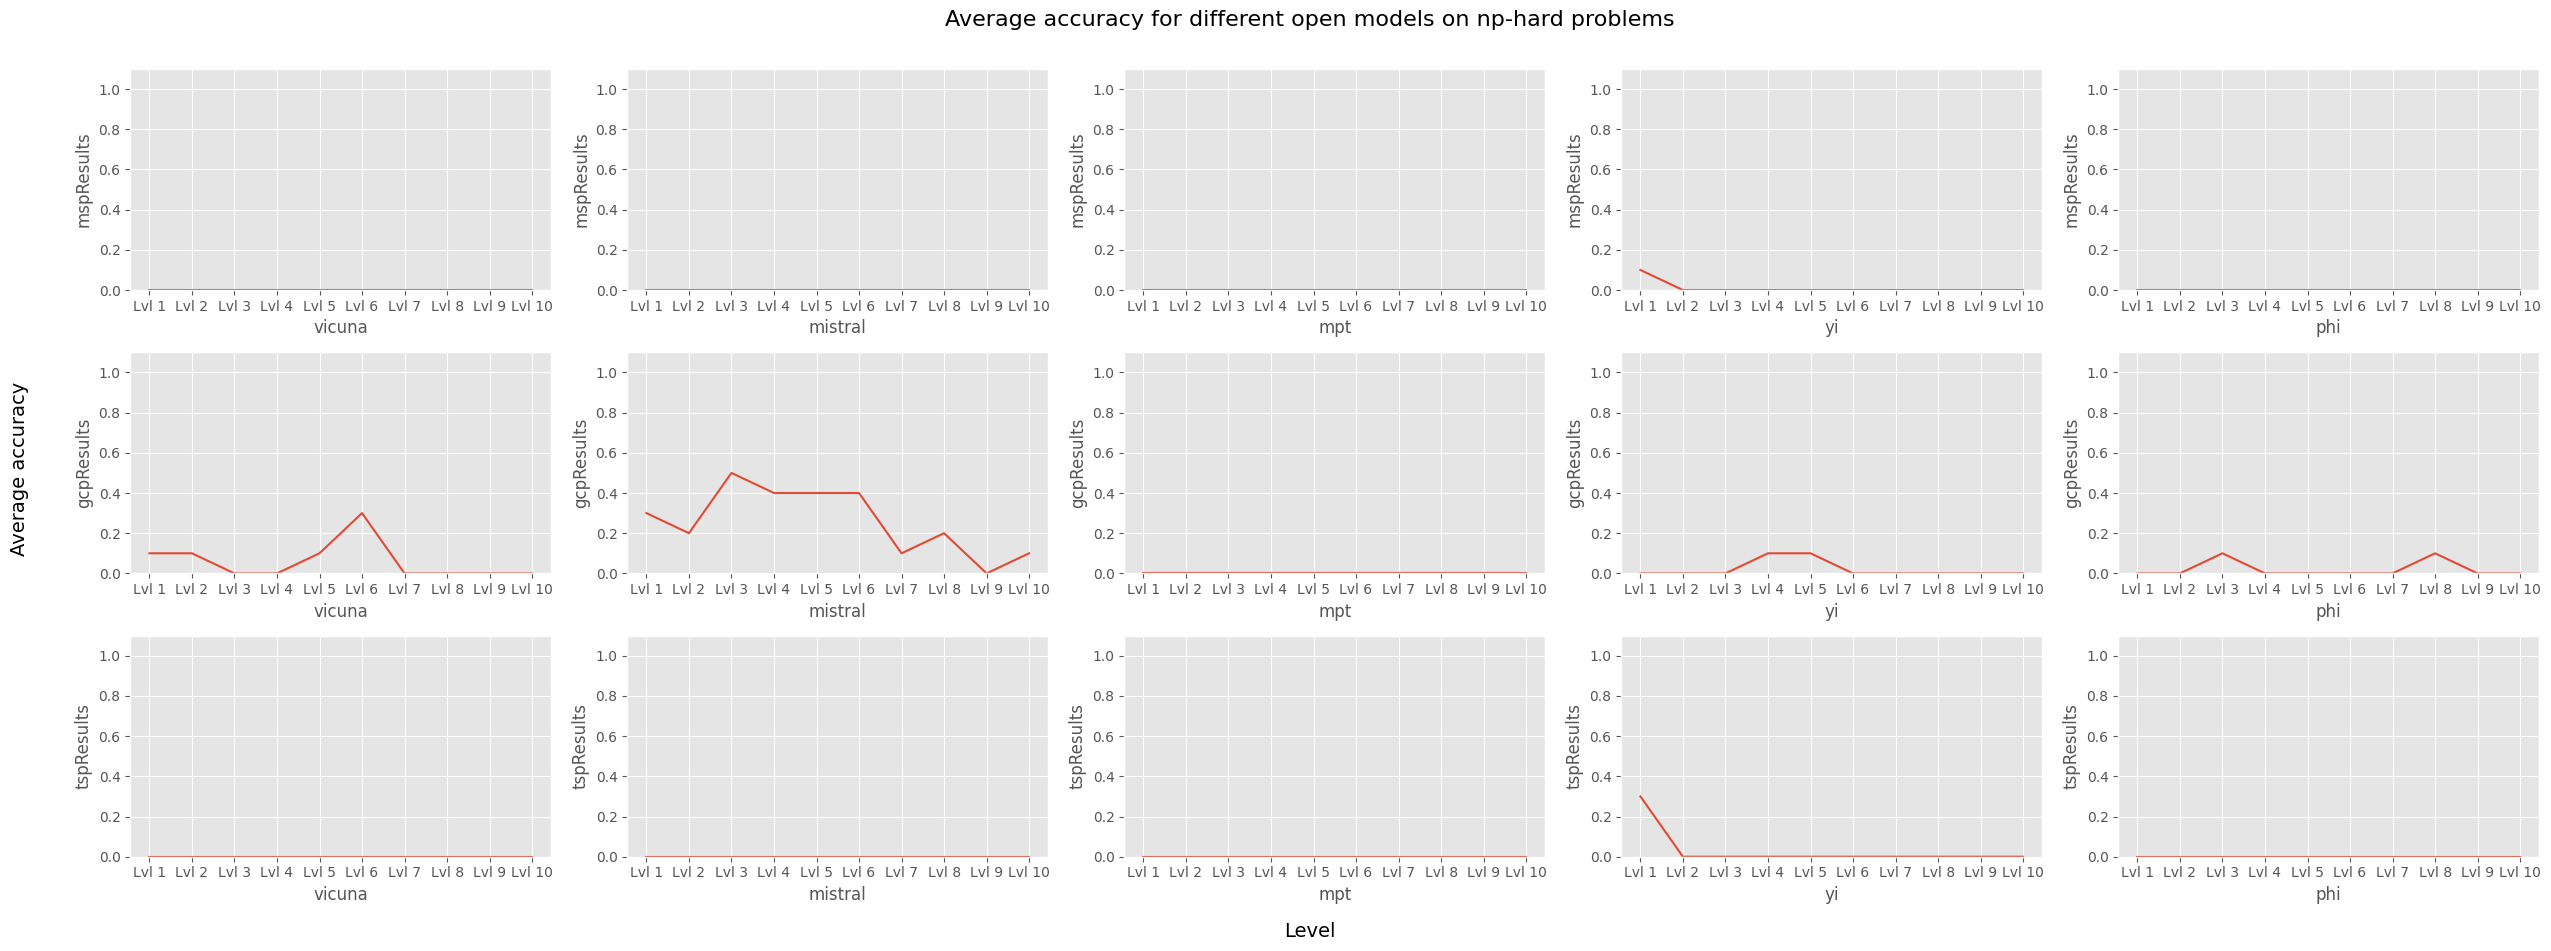

In [ ]:
plot_figure('Average accuracy', open_model_df, prefix='open')

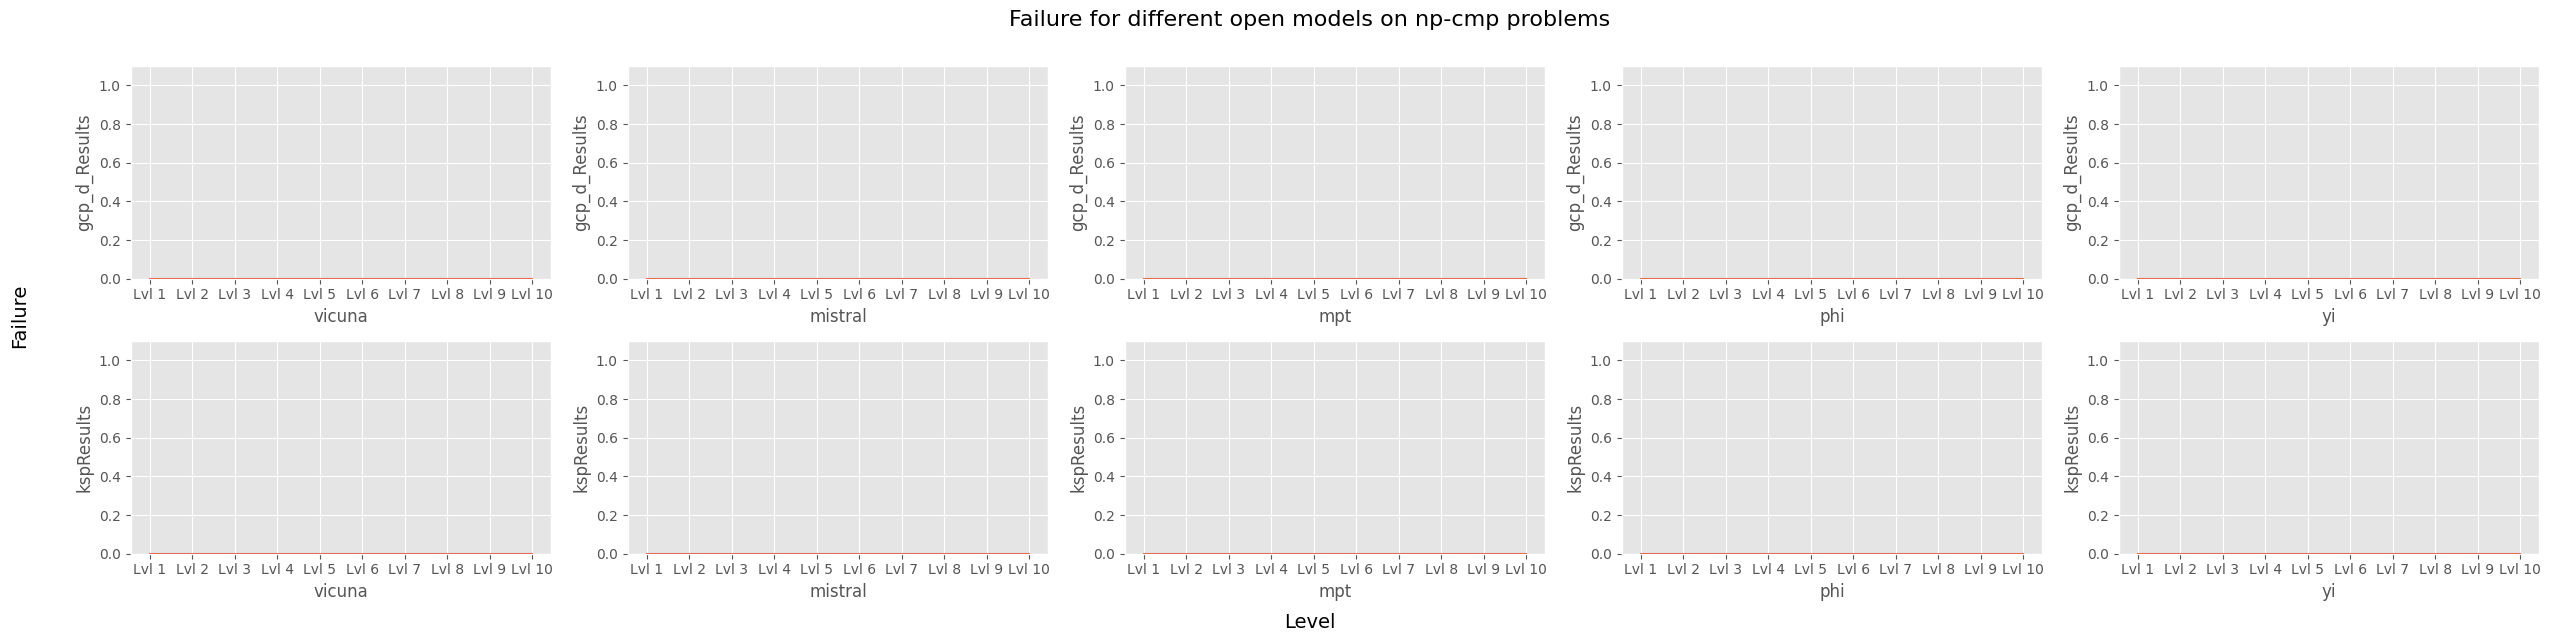

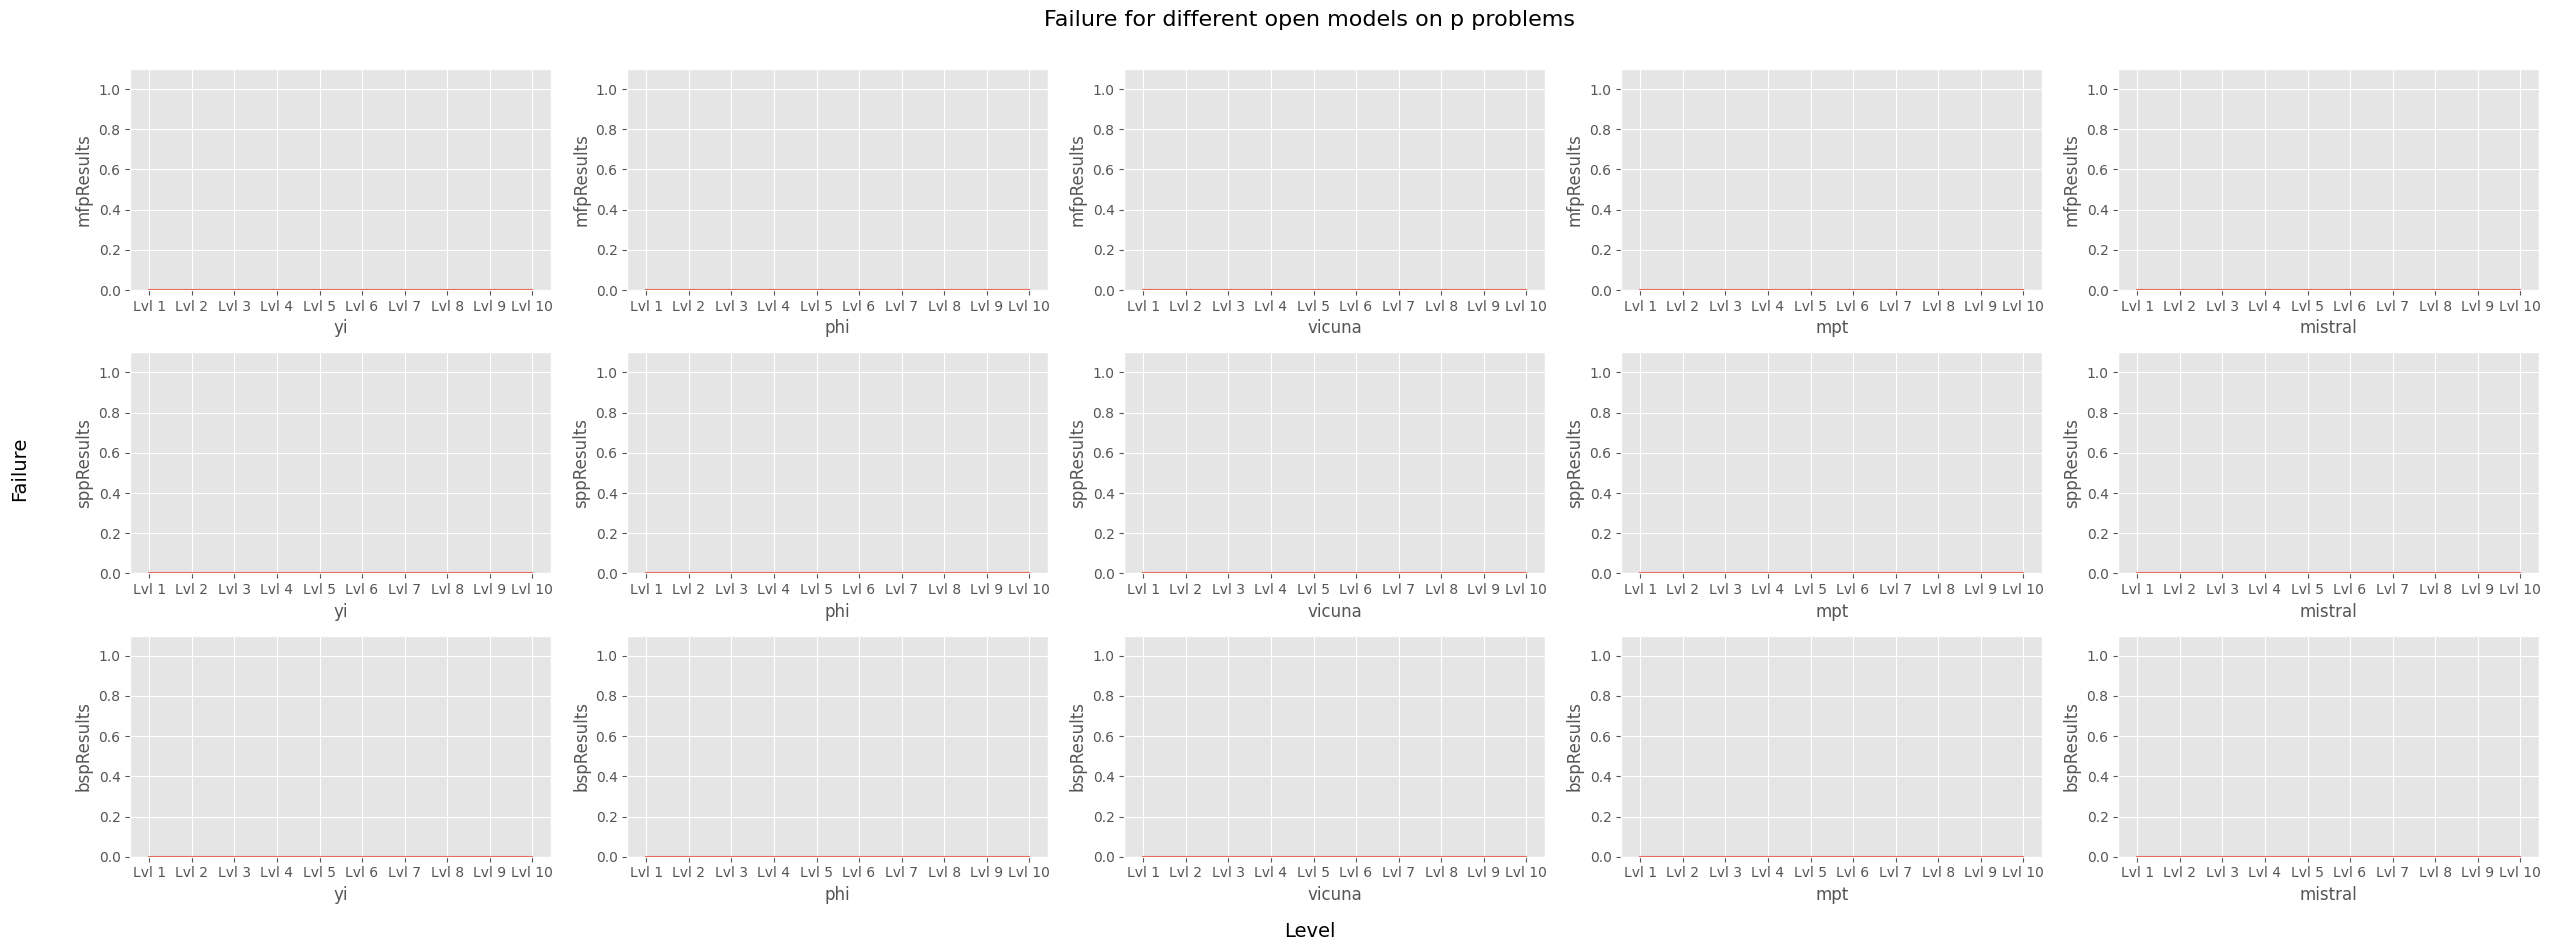

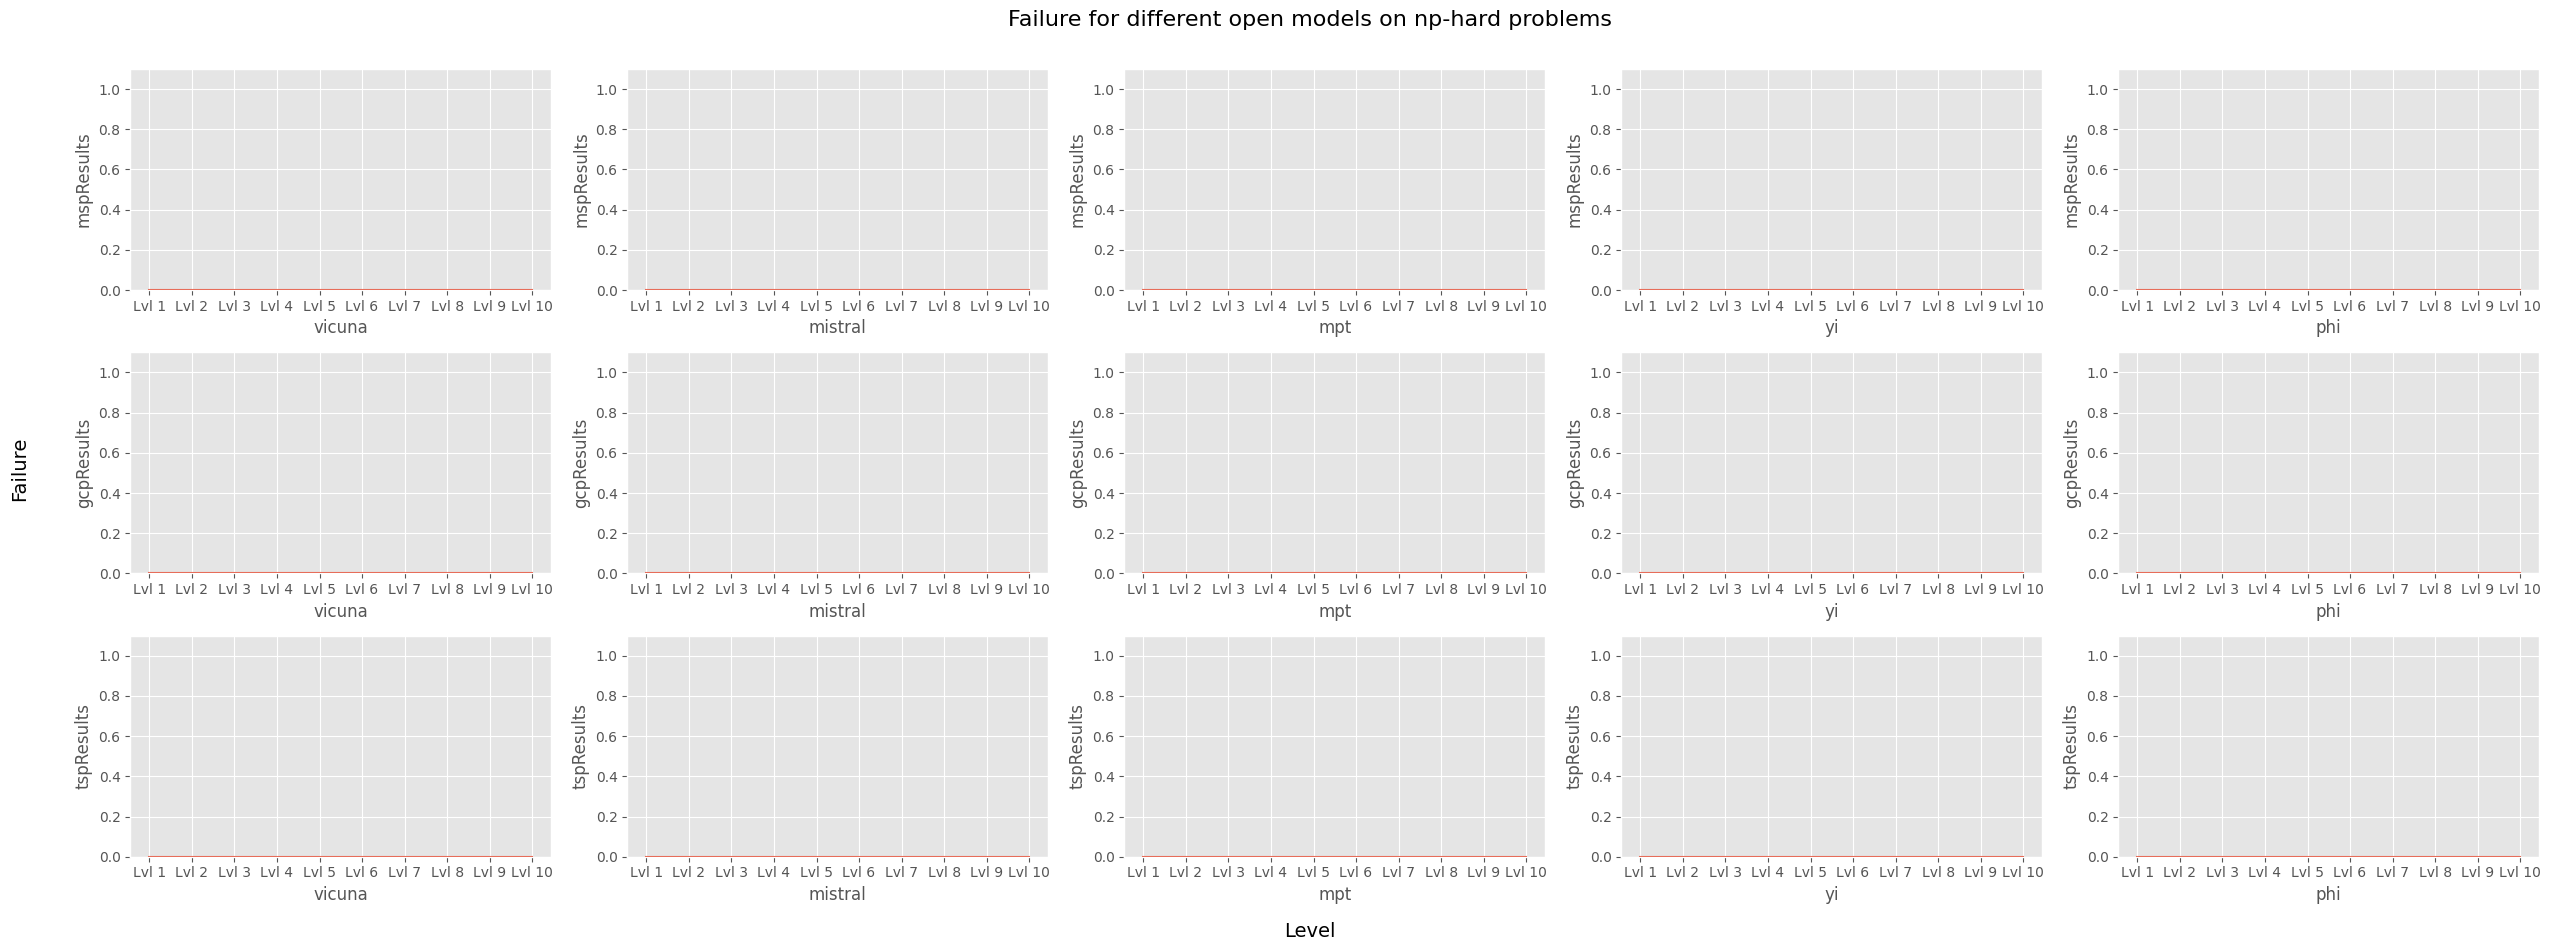

In [ ]:
plot_figure('Failure', open_model_df, prefix='open')

##### Close models

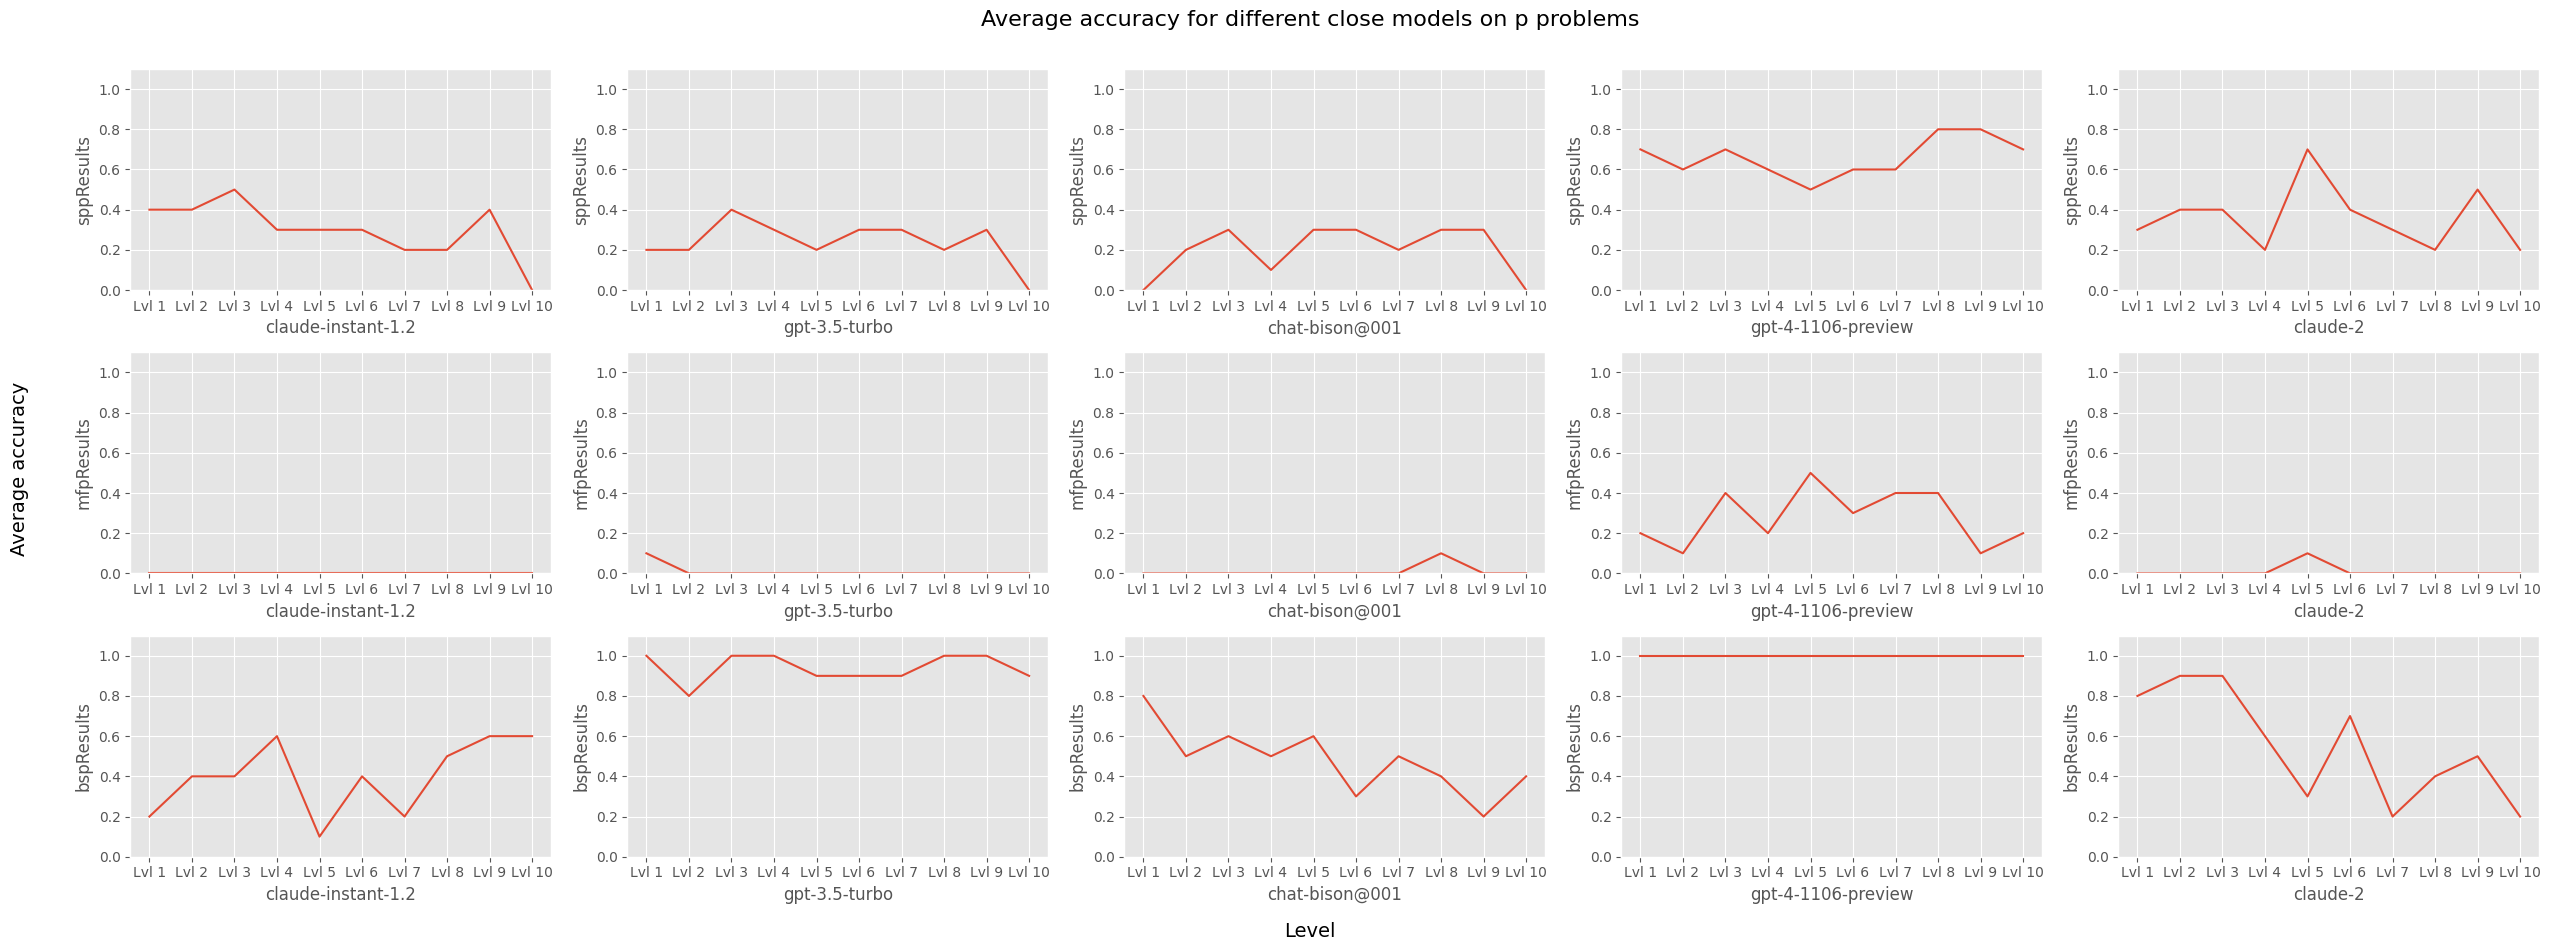

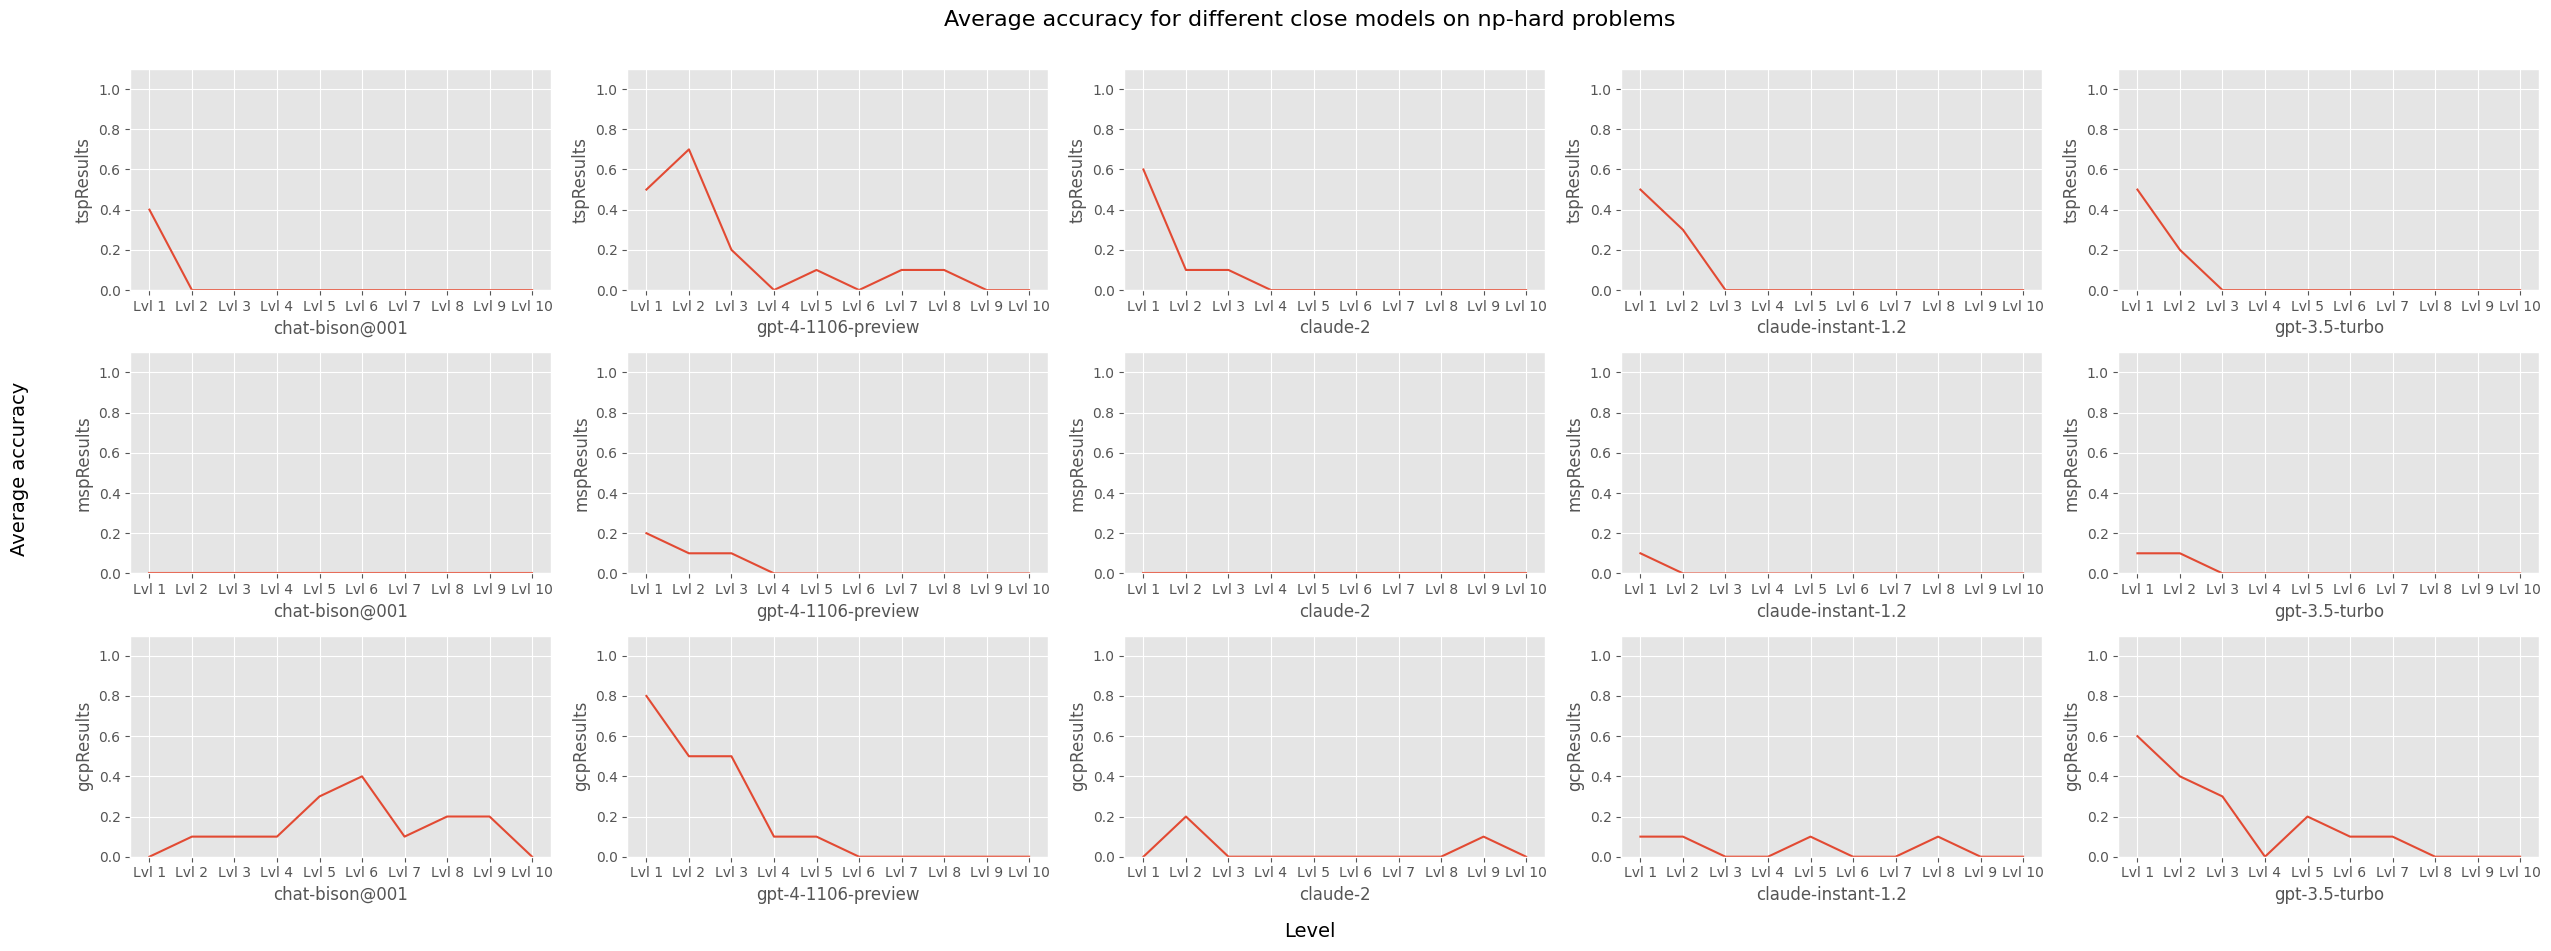

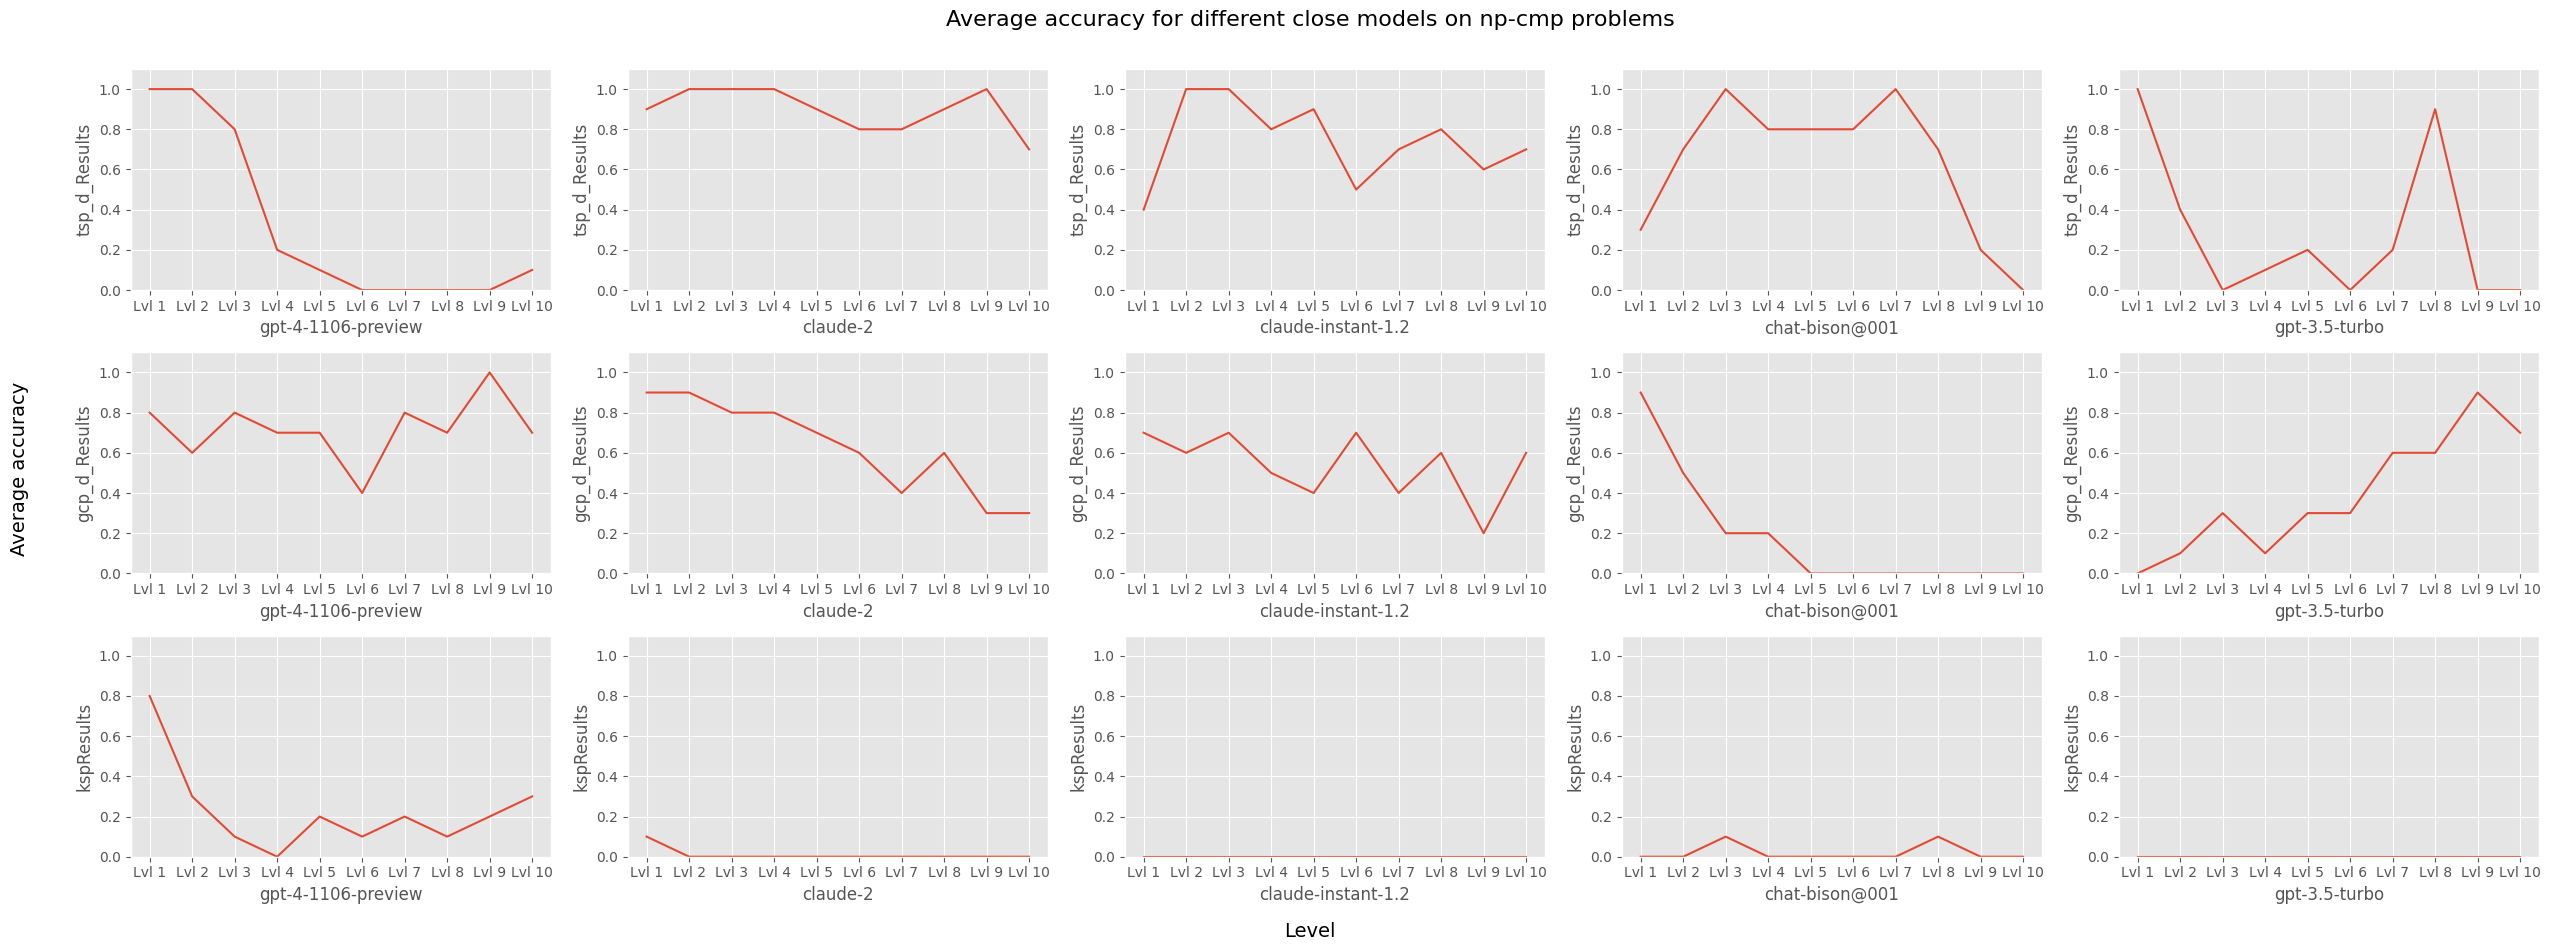

In [ ]:
plot_figure('Average accuracy', close_model_df, prefix='close')

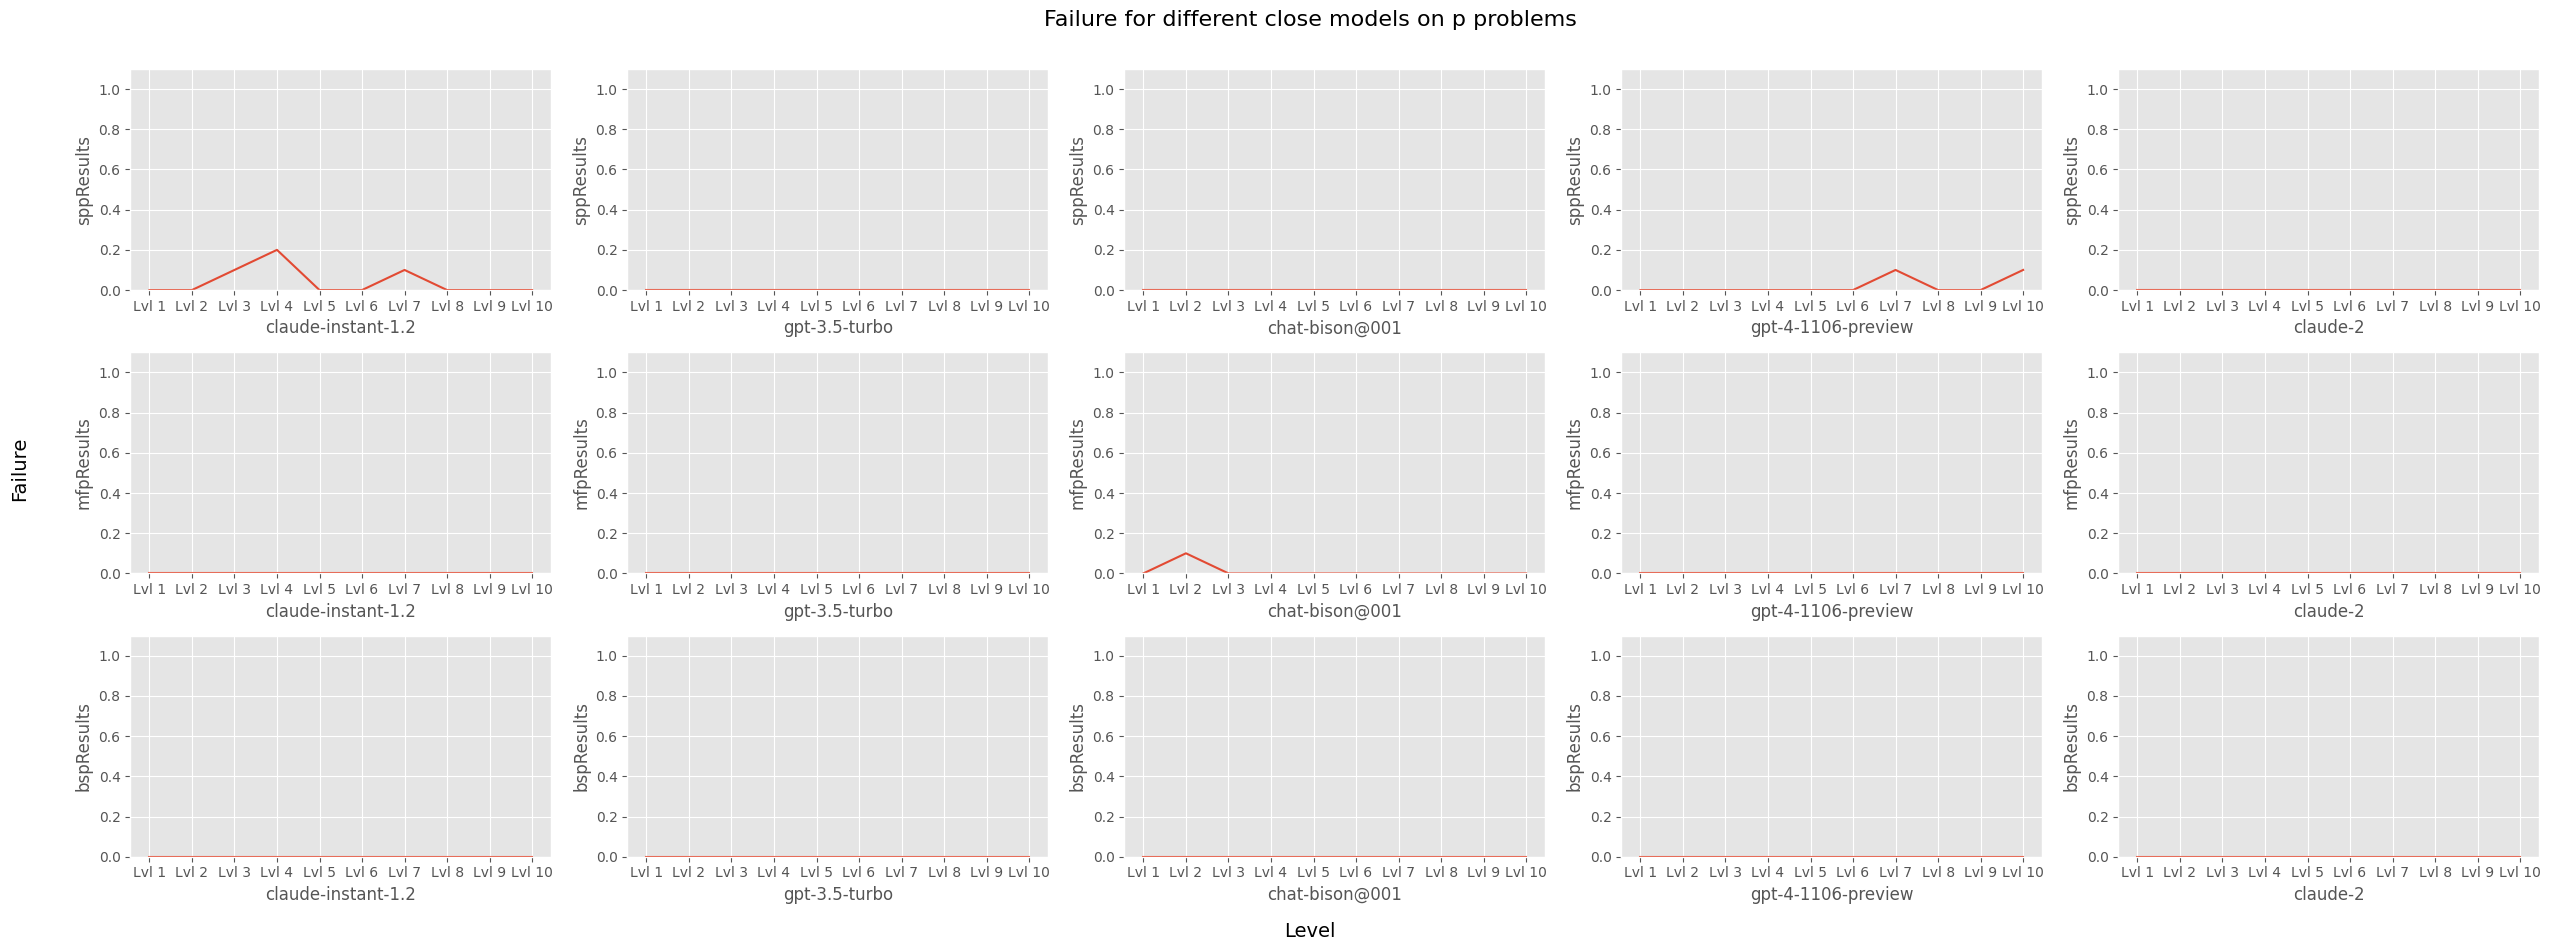

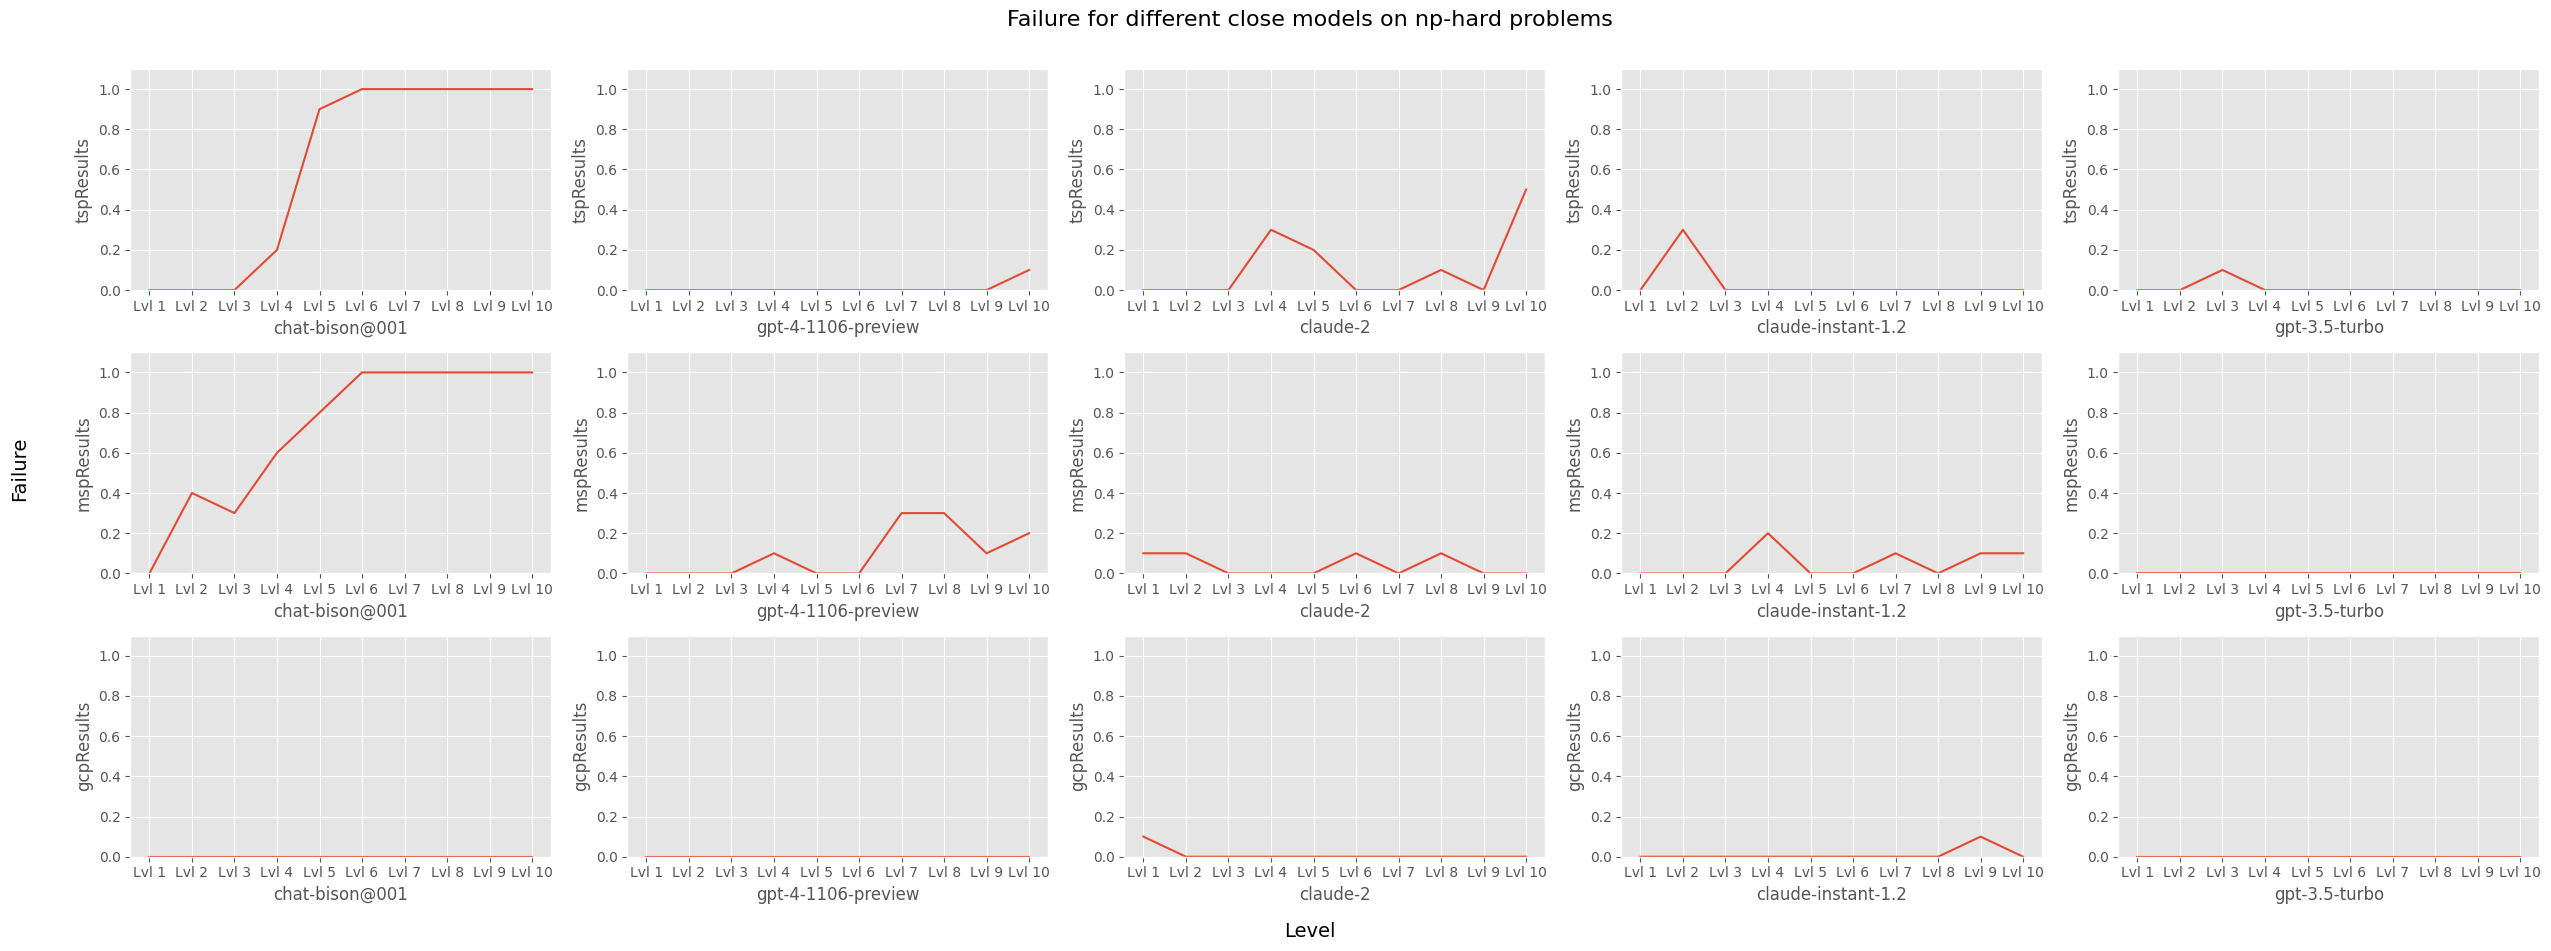

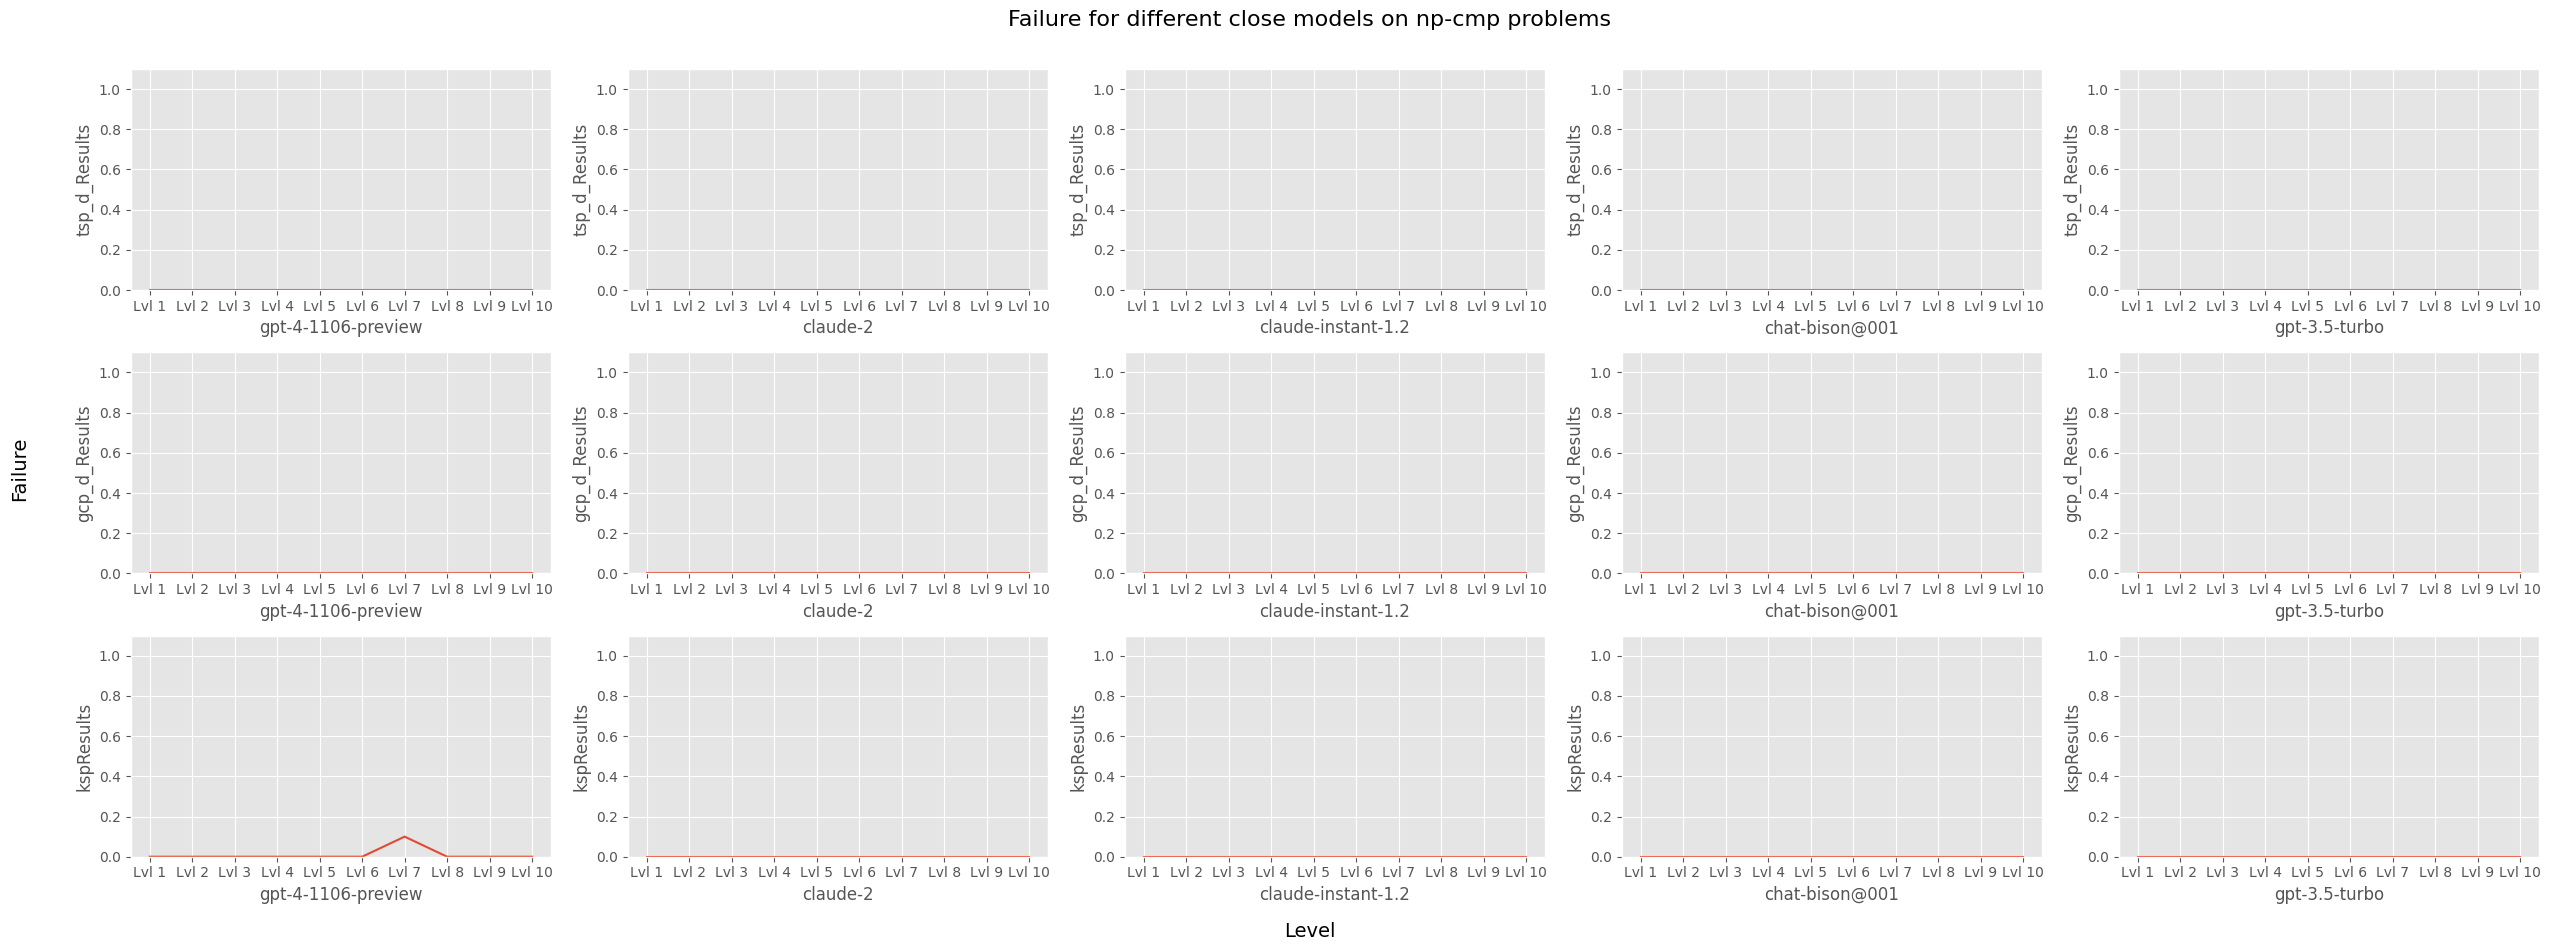

In [ ]:
plot_figure('Failure', close_model_df, prefix='close')

#### Save to csv file

In [ ]:
result_df.to_csv('results.csv', index=False)

In [ ]:
# import altair as alt

# def plot_figure(y_name, result_df, prefix=''):
#     # Create a single chart for all models and problems
#     chart = alt.Chart(result_df).mark_line().encode(
#         x=alt.X('level:N', sort=[f'Lvl {i+1}' for i in range(10)]),
#         y=alt.Y(y_name, scale=alt.Scale(domain=(0, 1)), title='Accuracy'),
#         # color='model:N',
#         column=alt.Column('model:N', sort=close_models, title=None),
#         # row=alt.Row('problem:N', sort=alt.SortField('problem_order', order='ascending')),
#         color = alt.Color('problem:N', scale=alt.Scale(scheme='category20'), title='Problem'),
#         tooltip=['problem:N']
#     ).properties(
#         width=240,
#         height=180
#     ).resolve_scale(
#         x='independent',
#         y='independent'
#     )

#     chart.save(f'figures/{prefix}_accuracy.html')
#     return chart

# # Call the function with your DataFrame and y_name
# plot_figure('Average accuracy', close_model_df, 'close')